In [1]:
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam
import numpy as np
from gym import wrappers
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=False):
        
        #rather than deque, use set np arrays, track index last saved
        #store tuple of reward, q-vals, next state for experience replay
        self.mem_size = max_size
        self.mem_cntr = 0
        
        #allocate table equal to rows of mem entries with cols of env observations (e.g. for lunar lander-> 8 possibile results)
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape))
        self.new_state_memory = np.zeros((self.mem_size, input_shape)) #possible actions for lunar lander-> 4
        dtype = np.int8 if self.discrete else np.float32
        
        #set dtype to index np array for experience replay, table will store either int or decimals depending on dtype 
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)
        
        #sampling transitions for eps, future reward at terminal state is zero, must accomodate and store incase
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    #add transitions to mem    
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        # store one hot encoding of actions, if appropriate
        if self.discrete:
            #retrieve num actions from cols of action_mem if discrete space
            actions = np.zeros(self.action_memory.shape[1])
            #ex: [0, 0, 0, 1, 0, 0, 0, 0] -> at state x, agent takes actions[3] = 1, goes to state_ y
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - done
        self.mem_cntr += 1

    #define sample size for mem; prefer to not have sequential observation samples, else correlations 
    #agent will inaccurately prioritise certain state-action pairs
    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        #select batch_size entries from range: [0, max_mem]
        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

def build_dqn(lr, n_actions, input_dims, fc1_dims, fc2_dims):
    model = Sequential([
                Dense(fc1_dims, input_shape=(input_dims,)),
                Activation('relu'),
                Dense(fc2_dims),
                Activation('relu'),
                Dense(n_actions)])

    model.compile(optimizer=Adam(lr=lr), loss='mse')

    return model

class DDQNAgent(object):
    #epsilon continues decreasing over time to ensure less random actions taken as optimal path will be found 
    #replace target net weights every 100 eps to update for action eval
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996,  epsilon_end=0.01,
                 mem_size=1000000, fname='ddqn_model.h5', replace_target=100):
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_min = epsilon_end
        self.batch_size = batch_size
        self.model_file = fname
        self.replace_target = replace_target
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions,
                                   discrete=True)
        self.q_eval = build_dqn(alpha, n_actions, input_dims, 256, 256)
        self.q_target = build_dqn(alpha, n_actions, input_dims, 256, 256)

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def choose_action(self, state):
    #insert axis along first-dim (row), ensures single-mem entries can be handled in addition to batches for NN input
        state = state[np.newaxis, :]
        rand = np.random.random()
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            #predict defined by keras, runs feed-fwd to compute output (vec of action q-vals)
            actions = self.q_eval.predict(state)
            action = np.argmax(actions)

        return action

    def learn(self):
        #ensure mem > batch so samples have sufficient variance
        if self.memory.mem_cntr > self.batch_size:
            state, action, reward, new_state, done = \
                                          self.memory.sample_buffer(self.batch_size)

            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action, action_values)

            #q_eval reps target net which uses optimal policy
            #q_pred reps estimated values of all actions for behavioral net
            q_next = self.q_target.predict(new_state)
            q_eval = self.q_eval.predict(new_state)
            q_pred = self.q_eval.predict(state)

            max_actions = np.argmax(q_eval, axis=1) #use behavioral net, q_eval to find best action 

            #apply q_target to find state-vals  & update in table for corresponding actions 
            q_target = q_pred

            batch_index = np.arange(self.batch_size, dtype=np.int32)

            #calc q-vals of optimal actions selected from behavioral net using target net 
            q_target[batch_index, action_indices] = reward + \
                    self.gamma*q_next[batch_index, max_actions.astype(int)]*done

            #train behavioral net, tune weights to minimise loss (difference); determine q_pred & take diff using it against q_target
            #difference applied across all state-val pairs of q_eval against optimal state-val pair of q_target
            _ = self.q_eval.fit(state, q_target, verbose=0)

            self.epsilon = self.epsilon*self.epsilon_dec if self.epsilon > \
                           self.epsilon_min else self.epsilon_min
            if self.memory.mem_cntr % self.replace_target == 0:
                self.update_network_parameters()

    def update_network_parameters(self):
        self.q_target.model.set_weights(self.q_eval.model.get_weights())

    def save_model(self):
        self.q_eval.save(self.model_file)

    def load_model(self):
        self.q_eval = load_model(self.model_file)
        # if we are in evaluation mode we want to use the best weights for
        # q_target
        if self.epsilon == 0.0:
            self.update_network_parameters()

episode:  0 score: -104.93  average score -104.93


C:\Users\Owner\Anaconda3\envs\pole-balance\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


episode:  1 score: -281.74  average score -193.34
episode:  2 score: -149.50  average score -178.72
episode:  3 score: -111.53  average score -161.92
episode:  4 score: -180.63  average score -165.67
episode:  5 score: -172.17  average score -166.75
episode:  6 score: -316.89  average score -188.20
episode:  7 score: -59.36  average score -172.09
episode:  8 score: -183.36  average score -173.34
episode:  9 score: -101.62  average score -166.17
episode:  10 score: -189.89  average score -168.33
episode:  11 score: -156.49  average score -167.34
episode:  12 score: -147.42  average score -165.81
episode:  13 score: -340.51  average score -178.29
episode:  14 score: -395.09  average score -192.74
episode:  15 score: -269.77  average score -197.55
episode:  16 score: -348.02  average score -206.41
episode:  17 score: -116.15  average score -201.39
episode:  18 score: -150.12  average score -198.69
episode:  19 score: -124.21  average score -194.97
episode:  20 score: -303.36  average scor

episode:  166 score: 274.05  average score 161.54
episode:  167 score: -14.24  average score 162.26
episode:  168 score: 267.73  average score 166.87
episode:  169 score: 273.60  average score 169.93
episode:  170 score: 248.58  average score 172.36
episode:  171 score: 263.68  average score 172.54
episode:  172 score: 285.67  average score 173.38
episode:  173 score: 3.60  average score 173.71
episode:  174 score: 264.45  average score 173.98
episode:  175 score: 263.87  average score 176.94
episode:  176 score: 257.90  average score 179.81
episode:  177 score: 248.07  average score 182.72
episode:  178 score: 281.09  average score 183.53
episode:  179 score: 277.69  average score 183.62
episode:  180 score: 280.91  average score 184.60
episode:  181 score: 280.10  average score 184.43
episode:  182 score: 313.12  average score 189.38
episode:  183 score: 284.89  average score 191.72
episode:  184 score: 275.51  average score 192.34
episode:  185 score: 278.35  average score 193.45
ep

episode:  330 score: 244.70  average score 252.46
episode:  331 score: 231.68  average score 252.32
episode:  332 score: 263.76  average score 251.90
episode:  333 score: 207.04  average score 251.28
episode:  334 score: 244.02  average score 250.71
episode:  335 score: 228.38  average score 253.69
episode:  336 score: 277.57  average score 254.00
episode:  337 score: 259.91  average score 254.17
episode:  338 score: 247.63  average score 254.15
episode:  339 score: 288.79  average score 254.21
episode:  340 score: 273.60  average score 256.91
episode:  341 score: 248.68  average score 256.48
episode:  342 score: 246.17  average score 256.36
episode:  343 score: 292.92  average score 256.39
episode:  344 score: 267.41  average score 258.23
episode:  345 score: 33.97  average score 256.09
episode:  346 score: 248.37  average score 256.31
episode:  347 score: 285.67  average score 256.38
episode:  348 score: 225.11  average score 255.86
episode:  349 score: 242.26  average score 255.67
e

episode:  495 score: 297.94  average score 225.47
episode:  496 score: 271.85  average score 225.61
episode:  497 score: 274.99  average score 225.92
episode:  498 score: 264.47  average score 226.19
episode:  499 score: 286.13  average score 226.49


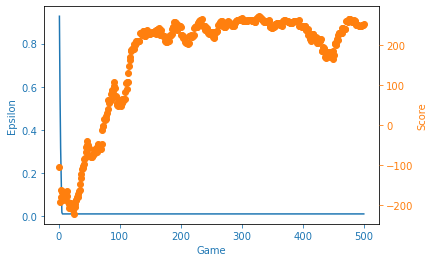

In [4]:
import gym

if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    ddqn_agent = DDQNAgent(alpha=0.0005, gamma=0.99, n_actions=4, epsilon=1.0, batch_size=64, input_dims=8)
    n_games = 500
    
    ddqn_scores = []
    eps_history = []
    
    env = wrappers.Monitor(env, 'tmp/lunar-lander', video_callable=lambda episode_id: True, force=True)
    
    for i in range(n_games):
        done = False
        score = 0
        observation = env.reset()
        while not done:
            action = ddqn_agent.choose_action(observation)
            observation_, reward, done, info = env.step(action) #state: observation, new_state: observation_
            score += reward
            ddqn_agent.remember(observation, action, reward, observation_, done)
            observation = observation_
            ddqn_agent.learn()
        eps_history.append(ddqn_agent.epsilon)
        ddqn_scores.append(score)
        
        avg_score = np.mean(ddqn_scores[max(0, i-100):(i+1)])
        #print('episode ', i, 'score %.2f' % score, 'average score %.2f', % avg_score)
        print('episode: ', i,'score: %.2f' % score,
              ' average score %.2f' % avg_score)
        
        if i % 10 == 0 and i > 0:
            ddqn_agent.save_model()
    
    filename = 'lunarlander-ddqn.png'
    x = [i + 1 for i in range(n_games)]
    plotLearning(x, ddqn_scores, eps_history, filename)

In [3]:
def plotLearning(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Game", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    #ax2.xaxis.tick_top()
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    #ax2.set_xlabel('x label 2', color="C1")
    ax2.set_ylabel('Score', color="C1")
    #ax2.xaxis.set_label_position('top')
    ax2.yaxis.set_label_position('right')
    #ax2.tick_params(axis='x', colors="C1")
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)